In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 
import numpy as np
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.unitroot import ADF as ARCH_ADF # type: ignore
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [26]:
data = pd.read_csv(r"C:\Users\yazid\Downloads\INVEST.csv", parse_dates=['observation_date'])
data.columns = ['DATE', 'INVEST']
data = data.set_index('DATE').asfreq('MS')  # monthly start freq
print(data.head())
print(data.tail())
data.columns

             INVEST
DATE               
1947-01-01  82.3793
1947-02-01  81.2734
1947-03-01  80.5653
1947-04-01  80.1894
1947-05-01  79.6067
               INVEST
DATE                 
2025-06-01  5555.2012
2025-07-01  5585.9770
2025-08-01  5624.5521
2025-09-01  5643.7486
2025-10-01  5655.4704


Index(['INVEST'], dtype='object')

In [27]:
data.head(100000)

,INVEST
DATE,
1947-01-01,82.3793
1947-02-01,81.2734
1947-03-01,80.5653
1947-04-01,80.1894
1947-05-01,79.6067
...,...
2025-06-01,5555.2012
2025-07-01,5585.9770
2025-08-01,5624.5521


In [28]:
data.columns

Index(['INVEST'], dtype='object')

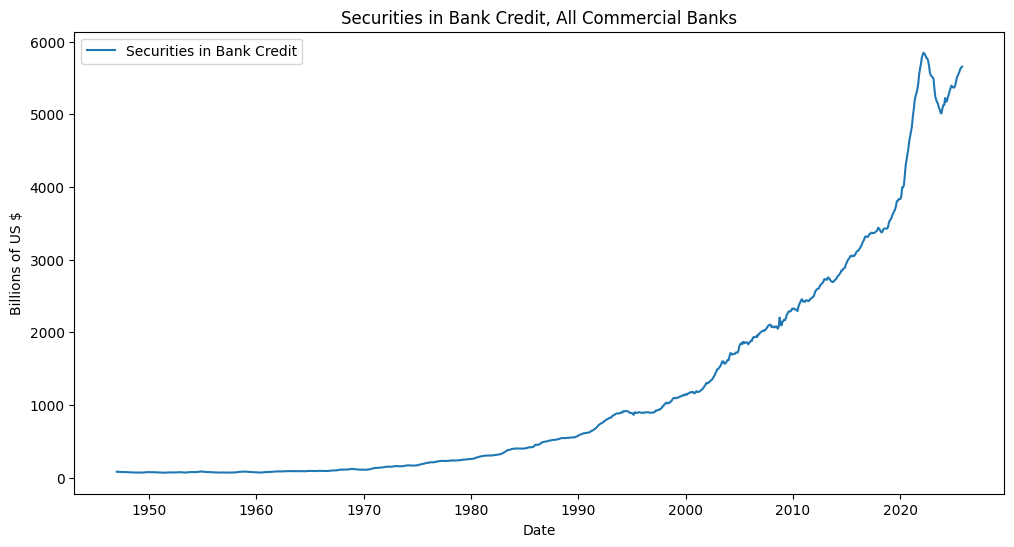

In [29]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['INVEST'], label='Securities in Bank Credit')
plt.title('Securities in Bank Credit, All Commercial Banks')
plt.xlabel('Date')
plt.ylabel('Billions of US $')
plt.legend()
plt.show()

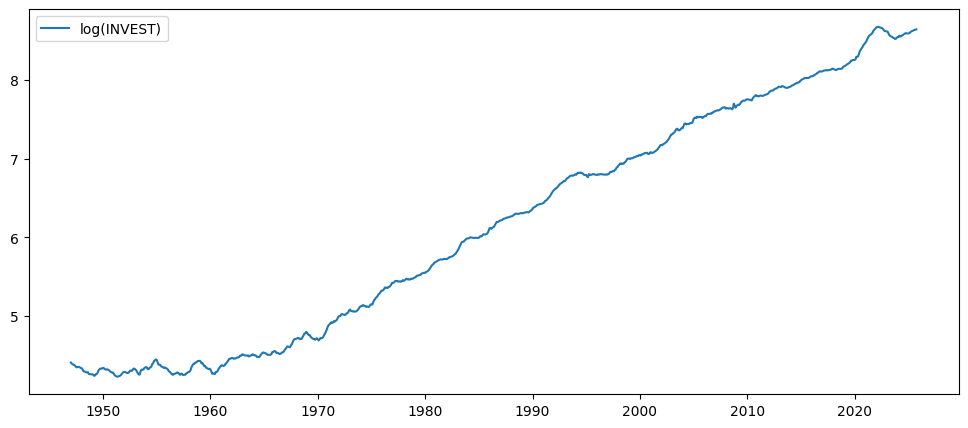

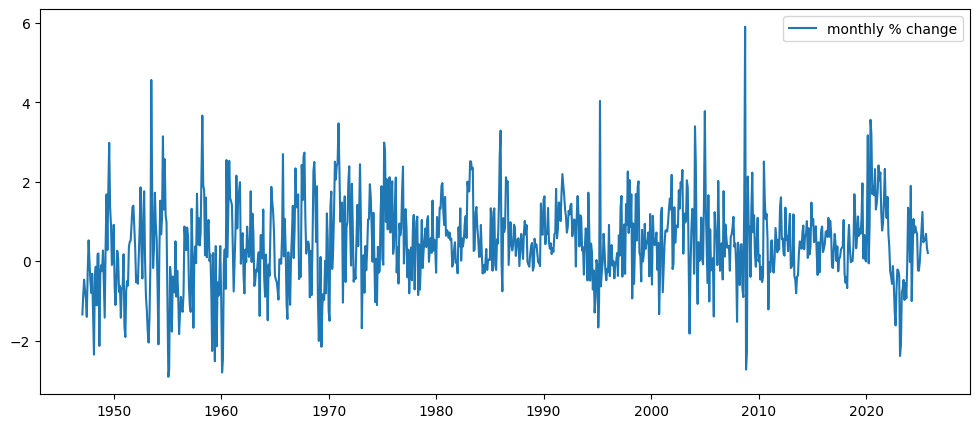

In [33]:
# log transform (if positive) and monthly pct change
data['log_INVEST'] = np.log(data['INVEST'])
data['pct_change'] = data['INVEST'].pct_change() * 100  # percentage

plt.figure(figsize=(12,5))
plt.plot(data['log_INVEST'], label='log(INVEST)')
plt.legend(); plt.show()

plt.figure(figsize=(12,5))
plt.plot(data['pct_change'], label='monthly % change')
plt.legend(); plt.show()

In [ ]:
# 3. Stationarity tests (ADF and KPSS)
def adf_test(series, title='Series'):
    print(f'--- ADF Test: {title} ---')
    res = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF stat {res[0]:.4f}, p-value {res[1]:.4f}')
    print('Used lags:', res[2], 'nobs:', res[3])
    for k,v in [('1%','0.01'),('5%','0.05'),('10%','0.10')]:
        pass
    print('crit values:', res[4])
    print()
 # The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test is a statistical test for stationarity in a time series, but it works opposite to the ADF test.
def kpss_test(series, regression='c', title='Series'):
    print(f'--- KPSS Test ({regression}): {title} ---')
    res = kpss(series.dropna(), regression=regression, nlags='auto')
    print(f'KPSS stat {res[0]:.4f}, p-value {res[1]:.4f}')
    print('Used lags:', res[2])
    print('crit values:', res[3])
    print()

adf_test(data['INVEST'], 'INVEST (level)')
kpss_test(data['INVEST'], regression='c', title='INVEST (level)')

adf_test(data['log_INVEST'], 'log(INVEST)')
kpss_test(data['log_INVEST'], regression='c', title='log(INVEST)')

adf_test(data['pct_change'], 'INVEST pct change')
kpss_test(data['pct_change'], regression='c', title='INVEST pct change')


--- ADF Test: INVEST (level) ---
ADF stat 3.8242, p-value 1.0000
Used lags: 17 nobs: 928
crit values: {'1%': np.float64(-3.4374162506455126), '5%': np.float64(-2.8646595140022946), '10%': np.float64(-2.568431020409111)}

--- KPSS Test (c): INVEST (level) ---
KPSS stat 3.6937, p-value 0.0100
Used lags: 19
crit values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

--- ADF Test: log(INVEST) ---
ADF stat 1.3700, p-value 0.9970
Used lags: 22 nobs: 923
crit values: {'1%': np.float64(-3.437454636606558), '5%': np.float64(-2.8646764401027336), '10%': np.float64(-2.5684400361180333)}

--- KPSS Test (c): log(INVEST) ---
KPSS stat 4.8297, p-value 0.0100
Used lags: 19
crit values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

--- ADF Test: INVEST pct change ---
ADF stat -6.6830, p-value 0.0000
Used lags: 22 nobs: 922
crit values: {'1%': np.float64(-3.437462363899248), '5%': np.float64(-2.8646798473884134), '10%': np.float64(-2.568441851017076)}

--- KPSS Test (c): INVEST pct 

C:\Users\yazid\AppData\Local\Temp\ipykernel_5880\2162801824.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series.dropna(), regression=regression, nlags='auto')
C:\Users\yazid\AppData\Local\Temp\ipykernel_5880\2162801824.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series.dropna(), regression=regression, nlags='auto')


In [43]:
data["log_INVEST"] = np.log(data["INVEST"])
data["d_log_INVEST"] = data["log_INVEST"].diff()
data = data.dropna()

<Figure size 1200x400 with 0 Axes>

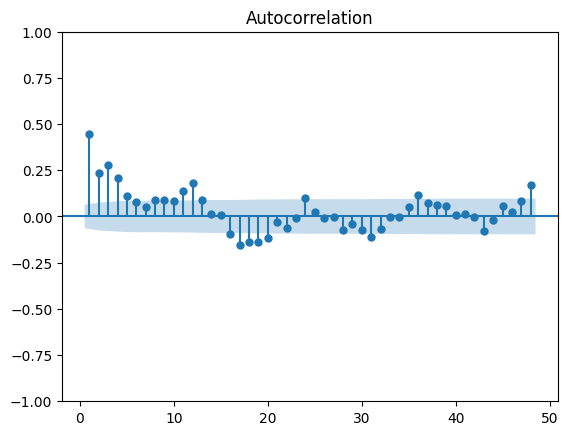

<Figure size 1200x400 with 0 Axes>

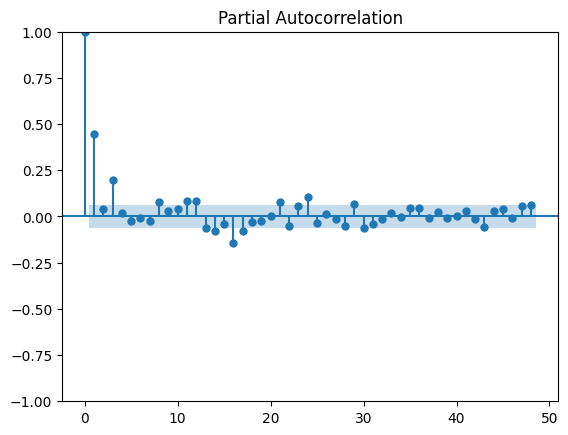

In [65]:
plt.figure(figsize=(12,4))
plot_acf(data["d_log_INVEST"], lags=48, zero=False)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(data["d_log_INVEST"], lags=48, method="ywm")
plt.show()

In [46]:
print(data.columns)
data.head()

Index(['INVEST', 'log_INVEST', 'pct_change', 'd_log_INVEST'], dtype='object')


,INVEST,log_INVEST,pct_change,d_log_INVEST
DATE,,,,
1947-02-01,81.2734,4.397819,-1.342449,-0.013515
1947-03-01,80.5653,4.389068,-0.871257,-0.008751
1947-04-01,80.1894,4.384391,-0.466578,-0.004677
1947-05-01,79.6067,4.377098,-0.726655,-0.007293
1947-06-01,78.8543,4.367602,-0.945147,-0.009496


In [ ]:
# 6. Using auto_arima to get candidate models (non-seasonal and seasonal)
# NOTE: set seasonal=True if you see seasonal periodicity (lags at 12)
auto = pm.auto_arima(
    data['log_INVEST'].dropna(),
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,             # let auto determine d
    seasonal=True, m=12, # set m=12 for monthly seasonality (change to 1 if no seasonality)
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    D=None,             # let auto determine seasonal diff
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)
print(auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-5845.493, Time=0.16 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-5955.479, Time=0.82 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-6096.168, Time=0.82 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-6076.764, Time=0.27 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-6153.810, Time=2.10 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-6102.914, Time=0.84 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=-6151.775, Time=3.39 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=-6151.275, Time=3.38 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=-6114.048, Time=1.85 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=-6124.471, Time=1.81 sec
 ARIMA(0,2,1)(2,0,2)[12]             : AIC=-6150.898, Time=5.96 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-5894.406, Time=1.06 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=-6196.986, Time=2.18 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=-6162.090, Time=1.76 sec
 ARIM

BEST MODEL IS THE ONE WITH THE LOWER: AIC: ARIMA(1,2,1)(2,0,1)[12]

In [52]:
# 7. Fit a SARIMAX model using statsmodels (example: replace orders with auto summary)
# Example placeholder: (p,d,q) = auto.order, seasonal_order = auto.seasonal_order
order = auto.order
seasonal_order = auto.seasonal_order
print("Fitting SARIMAX", order, seasonal_order)

model = SARIMAX(data['log_INVEST'].dropna(), order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(maxiter=200)
print(res.summary())

Fitting SARIMAX (1, 2, 1) (2, 0, 1, 12)
                                     SARIMAX Results                                      
Dep. Variable:                         log_INVEST   No. Observations:                  945
Model:             SARIMAX(1, 2, 1)x(2, 0, 1, 12)   Log Likelihood                3011.078
Date:                            Sun, 23 Nov 2025   AIC                          -6010.156
Time:                                    13:11:20   BIC                          -5981.223
Sample:                                02-01-1947   HQIC                         -5999.114
                                     - 10-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4432      0.022     19.889      0.000       0.400       0

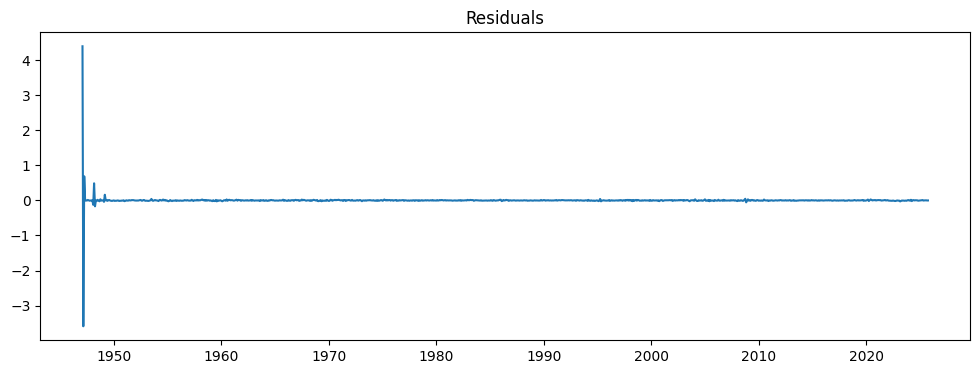

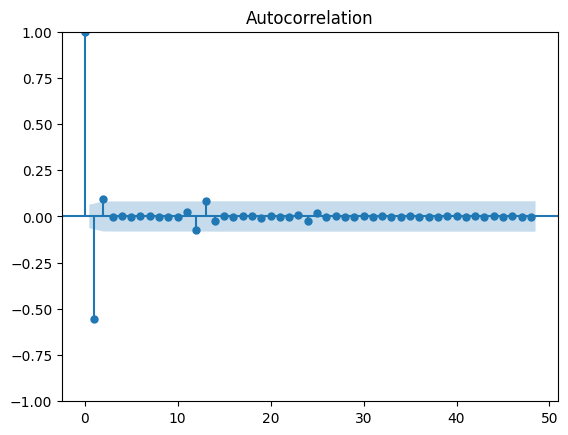

       lb_stat     lb_pvalue
12  306.923061  1.650475e-58
24  314.560651  1.938892e-52
36  315.027723  2.787286e-46
Jarque-Bera stat, p-value: SignificanceResult(statistic=np.float64(8455042.639705647), pvalue=np.float64(0.0))
ARCH test: (np.float64(29.865654328361572), np.float64(0.0009010700490572784), 3.048814215411198, 0.000817127318485913)


In [60]:
# 8. Diagnostics
# residuals
resid = res.resid
plt.figure(figsize=(12,4))
plt.plot(resid); plt.title('Residuals'); plt.show()

# Residual ACF
plot_acf(resid.dropna(), lags=48); plt.show()

# Ljung-Box for residuals
lb = acorr_ljungbox(resid.dropna(), lags=[12,24,36], return_df=True)
print(lb)

# Normality test
from scipy.stats import jarque_bera
jb = jarque_bera(resid.dropna())
print('Jarque-Bera stat, p-value:', jb)

# ARCH test for heteroscedasticity
from arch.unitroot import ADF as ARCH_ADF  # type: ignore # (optional)
# simpler: use statsmodels' het_arch
from statsmodels.stats.diagnostic import het_arch
print('ARCH test:', het_arch(resid.dropna()))

c:\Users\yazid\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 755.5664, RMSE: 791.4540


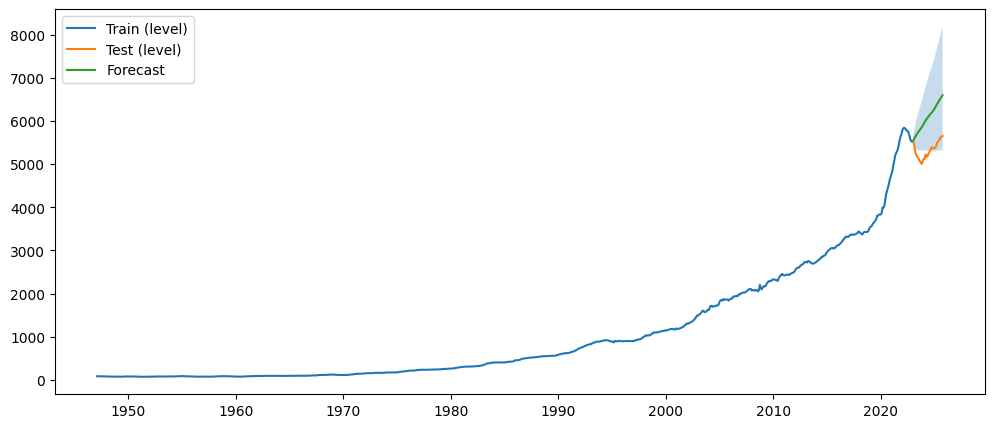

In [64]:
# 9. Forecasting & evaluation (train/test)
# Split last 36 months as test (adjust as needed)
train = data['log_INVEST'][:'2022-12-01']  # choose cutoff; change as required
test = data['log_INVEST']['2023-01-01':]   # adjust dates

model_train = SARIMAX(train.dropna(), order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
res_train = model_train.fit(disp=False)

n_steps = len(test)
pred = res_train.get_forecast(steps=n_steps)
pred_mean_log = pred.predicted_mean
pred_ci = pred.conf_int()

# convert back from log to level
pred_mean = np.exp(pred_mean_log)
test_level = np.exp(test)

# metrics
mae = mean_absolute_error(test_level, pred_mean)
rmse = math.sqrt(mean_squared_error(test_level, pred_mean))
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# plot
plt.figure(figsize=(12,5))
plt.plot(np.exp(train), label='Train (level)')
plt.plot(test_level, label='Test (level)')
plt.plot(pred_mean, label='Forecast')
plt.fill_between(pred_ci.index,
                 np.exp(pred_ci.iloc[:,0]),
                 np.exp(pred_ci.iloc[:,1]), alpha=0.25)
plt.legend(); plt.show()
